In [17]:
import numpy as np
import os
import scipy.stats as stats
import scipy.io as io
import networkx as nx
import random
import itertools
import glob
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve,roc_auc_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from scipy.io import loadmat, savemat
#from fracModel import fracOrdUU
from collections import Counter
from collections import defaultdict
from numpy import arange,array,ones,linalg
from sklearn.linear_model import LinearRegression
import pandas as pd
import powerlaw
import os.path
from os import path
import pickle
import warnings
warnings.filterwarnings("ignore")
print(random.random())
plt.rcParams.update({'font.size': 20})

0.5502515396022051


In [18]:
##Calculate entropy
def Entropy_MC(s,b,k,beta,gamma,st_in,shift):
    #s = s[st_in:min(st_in+shift,len(s))]
    #s = add_indel_sub_noise(s,p)
    inv, l, n = k-b, len(s), 4**k
    T=np.zeros((n,n))
    count = [0]*n
    word_list = [''.join(x) for x in itertools.product('acgt', repeat=k)]
    wd = dict(zip(word_list, list(range(len(word_list)))))
    uu = []
    for i in range(k,l-b):
        n1, n2 = wd[s[i-k:i]], wd[s[i-k+b:i+b]]
        T[n1,n2] += 1
        count[n1] += 1
        
    wo_next = [''.join(x) for x in itertools.product('acgt', repeat=b)]
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            T[i,j] = (T[i,j]+beta)/(count[i]+4**b*beta)
    sum_count = np.sum(count)+4**k*gamma
    
    prob = [(count[i]+gamma)/sum_count for i in range(len(count))] 
    n = len(T)
    H = 0
    F = []
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            F.append(T[i,j])
            H-=prob[i]*T[i,j]*np.log2(T[i,j])
    return F,H

In [19]:
# Random sequences
def seq_generator(length):
    s_origin= [random.choice('acgt') for _ in range(length)]
    s_final = ''.join(s_origin)
    return s_final


In [20]:
# add_mutations: region: from the start to the end
# mutation probability: p
# mode: mutation: 1 ; deletion: 2; insertion: 3

def noise_addition1(s,starts,ends,ps,modes):
    nucleotides = ['a', 'c', 'g', 't']
    sl = list(s)
    for i,mode in enumerate(modes):
        print(i,mode)
        start = starts[i]
        end = ends[i]
        p = ps[i]

        if mode == 1:
            for i in range(start,end):
                r = random.random()
                if r < p:
                    new_nucle = nucleotides.copy()
                    new_nucle.remove(sl[i])
                    sl[i] = random.choice(new_nucle)

        if mode == 2:
            for i in range(start,end):
                r = random.random()
                if r < p:
                    sl[i] = ''

        if mode == 3:
            for i in range(start,end):
                r = random.random()
                if r < p:
                    sl[i] = sl[i]+random.choice(nucleotides)    
                    print(sl[i])  
    print(sl)                       
    seq_processed = ''.join(sl)
    return seq_processed
            

In [21]:
# add_mutations: region: from the start to the end
# mutation probability: p
# mode probability (p1, p2): mutation: p1; deletion: p2; insertion: 1-p1-p2


def noise_addition2(s,starts,ends,ps,mode_probabilities):
    nucleotides = ['a', 'c', 'g', 't']
    sl = list(s)
    for i,modep in enumerate(mode_probabilities):
        start = starts[i]
        end = ends[i]
        p = ps[i]
        #moder = random.random()
        p1 = modep[0]
        p2 = modep[1]
        
        for i in range(start,end):
            r = random.random()
            if r < p:
                moder = random.random()
                if moder < p1:
                    new_nucle = nucleotides.copy()
                    new_nucle.remove(sl[i])
                    sl[i] = random.choice(new_nucle)

                elif moder < p1+p2:
                    sl[i] = ''              

                else:
                    sl[i] = sl[i]+random.choice(nucleotides) 
    
    seq_processed = ''.join(sl)
    return seq_processed

In [27]:
def PCAs(seqs,st_in,L,shift,ind_a,ind_b):
    b = 1
    k = 4
    beta = 0.5
    gamma = 0.5
    X = []
    for s in seqs:
        F,en = Entropy_MC(s,b,k,beta,gamma,st_in,shift)
        X.append(F)
    X = np.array(X)
    X = preprocessing.scale(X)
    print(X.shape)
    from sklearn.decomposition import PCA
    pca = PCA(n_components = 2)
    principalComponents = pca.fit_transform(X)
    return principalComponents

(1050, 1024)


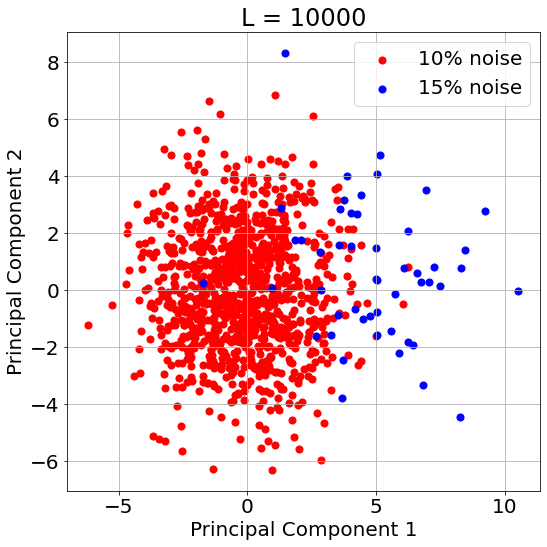

In [28]:
#Example
L = 10000
seq1 = seq_generator(L)
starts = [0]
ends = [L]
ps = [0.1]
ps_2 = [0.15]
mode_probabilities = [[1/3,1/3]]

seqs = []
N = 1050
ind_a = []
ind_b = []
for i in range(N):
    if i>=1000:
        seq2 = noise_addition2(seq1,starts,ends,ps_2,mode_probabilities)
        seqs.append(seq2)
        ind_b.append(i)
    else:
        seq1_noise = noise_addition2(seq1,starts,ends,ps,mode_probabilities)
        seqs.append(seq1_noise)
        ind_a.append(i)
st_in = 0
shift = L
targets = ['10% noise','15% noise']
principalComponents = PCAs(seqs,st_in,L,shift,ind_a,ind_b)

principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('L = {}'.format(L))
ax.scatter(principalDf.loc[ind_a, 'principal component 1']
                   , principalDf.loc[ind_a, 'principal component 2']
                   , c = 'red'
                   , s = 50)
ax.scatter(principalDf.loc[ind_b, 'principal component 1']
                   , principalDf.loc[ind_b, 'principal component 2']
                   , c = 'blue'
                   , s = 50)
ax.legend(targets,loc = 'upper right')
ax.grid()
fig.tight_layout()
fig.savefig('PCA_test.png')
fig.show()

In [ ]:
#Example
L = 10000
seq1 = seq_generator(L)
starts = [0]
ends = [L]
ps = [0.01]

mode_probabilities = [[1/3,1/3]]
shift = 3000
starts_2 = [4000]
ends_2 = [4000+shift]
ps_2 = [0.05]
mode_probabilities_2 = [[1/3,1/3]]
seqs = []
N = 1050
ind_a = []
ind_b = []
targets = ['1% noise','5% noise in a block']
for i in range(N):
    r = random.random()
    seq1_noise = noise_addition2(seq1,starts,ends,ps,mode_probabilities)
    if i>=1000:
        seq2 = noise_addition2(seq1_noise,starts_2,ends_2,ps_2,mode_probabilities_2)
        seqs.append(seq2)
        ind_b.append(i)
    else:
        seqs.append(seq1_noise)
        ind_a.append(i)
st_in = 0
principalComponents = PCAs(seqs,st_in,L,shift,ind_a,ind_b)

principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('L = {}, R = {}'.format(L,shift))
ax.scatter(principalDf.loc[ind_a, 'principal component 1']
                   , principalDf.loc[ind_a, 'principal component 2']
                   , c = 'red'
                   , s = 50)
ax.scatter(principalDf.loc[ind_b, 'principal component 1']
                   , principalDf.loc[ind_b, 'principal component 2']
                   , c = 'blue'
                   , s = 50)
ax.legend(targets,loc = 'upper right')
ax.grid()
fig.tight_layout()
fig.savefig('PCA_test.png')
fig.show()   